In [0]:
!pip install mxnet-cu100

In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

ctx = mx.gpu()

#Getting MNIST dataset

In [0]:
def transform(data, label):
    return nd.moveaxis(data.astype('float32'), 2, 0)/255.0, label.astype('float32')

train_mnist = gluon.data.vision.datasets.MNIST(train = True, transform = transform)
test_mnist = gluon.data.vision.datasets.MNIST(train = False, transform = transform)

In [0]:
image, label = train_mnist[5]
image.shape, label.shape

((1, 28, 28), ())

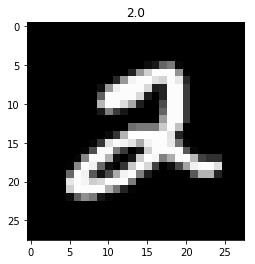

In [0]:
plt.imshow(image[0].asnumpy(), cmap = 'gray')
plt.title(label)
plt.show()

In [0]:
batch_size = 64
train_data = gluon.data.DataLoader(train_mnist, batch_size, True)
test_data = gluon.data.DataLoader(test_mnist, batch_size, False)

##Defining Batch Norm Layer

In [0]:
def batch_norm(x, gamma, beta, momentum = 0.8, eps = 1e-5, name = '', training = True):
    global moving_means, moving_vars

    if len(x.shape) not in (2, 4):
        raise ValueError('Only dense and cnn layers are suppported.')

    if len(x.shape) == 2:
        mean = nd.mean(x, axis=0)
        variance = nd.mean((x - mean) ** 2, axis=0)
        if training:
            x_hat = (x - mean) * 1.0 / nd.sqrt(variance + eps)
        else:
            x_hat = (x - moving_means[name]) * 1.0 / nd.sqrt(moving_vars[name] + eps)
        out = gamma * x_hat + beta

    elif len(x.shape) == 4:
        N, C, H, W = x.shape
        mean = nd.mean(x, axis=(0,2,3))
        variance = nd.mean((x - mean.reshape((1, C, 1, 1))) ** 2, axis=(0, 2, 3))
        x_hat = (x - mean.reshape((1, C, 1, 1))) * 1.0 / nd.sqrt(variance.reshape((1, C, 1, 1)) + eps)
        if training:
            x_hat = (x - mean.reshape((1, C, 1, 1))) * 1.0 / nd.sqrt(variance.reshape((1, C, 1, 1)) + eps)
        else:
            x_hat = (x - moving_means[name].reshape((1, C, 1, 1))) * 1.0 \
                / nd.sqrt(moving_vars[name].reshape((1, C, 1, 1)) + eps)
        out = gamma.reshape((1, C, 1, 1)) * x_hat + beta.reshape((1, C, 1, 1))

    try:
        moving_means, moving_vars
    except:
        moving_means, moving_vars = {}, {}

    if name not in moving_means:
        moving_means[name] = mean
    else:
        moving_means[name] = moving_means[name] * momentum + mean * (1.0 - momentum)
    if name not in moving_vars:
        moving_vars[name] = variance
    else:
        moving_vars[name] = moving_vars[name] * momentum + variance * (1.0 - momentum)
    return out

##Initializing model parameters and batch normal parameters

In [0]:
weight_scale = .01

W1 = nd.random_normal(shape=(20, 1, 3,3), scale=weight_scale, ctx=ctx)
b1 = nd.random_normal(shape=20, scale=weight_scale, ctx=ctx)

gamma1 = nd.random_normal(shape=20, loc=1, scale=weight_scale, ctx=ctx)
beta1 = nd.random_normal(shape=20, scale=weight_scale, ctx=ctx)

W2 = nd.random_normal(shape=(50, 20, 5, 5), scale=weight_scale, ctx=ctx)
b2 = nd.random_normal(shape=50, scale=weight_scale, ctx=ctx)

gamma2 = nd.random_normal(shape=50, loc=1, scale=weight_scale, ctx=ctx)
beta2 = nd.random_normal(shape=50, scale=weight_scale, ctx=ctx)

W3 = nd.random_normal(shape=(800, 128), scale=weight_scale, ctx=ctx)
b3 = nd.random_normal(shape=128, scale=weight_scale, ctx=ctx)

gamma3 = nd.random_normal(shape=128, loc=1, scale=weight_scale, ctx=ctx)
beta3 = nd.random_normal(shape=128, scale=weight_scale, ctx=ctx)

W4 = nd.random_normal(shape=(128, 10), scale=weight_scale, ctx=ctx)
b4 = nd.random_normal(shape=10, scale=weight_scale, ctx=ctx)

params = [W1, b1, gamma1, beta1, W2, b2, gamma2, beta2, W3, b3, gamma3, beta3, W4, b4]

for param in params:
    param.attach_grad()

In [0]:
def relu(x):
    return nd.maximum(x, 0)

In [0]:
def softmax(linear):
    exp = nd.exp(linear - nd.max(linear))
    partition = nd.sum(exp).reshape((-1, 1))
    return exp / partition

##Building the model

In [0]:
def model(x, training = True):
    h1_conv = nd.Convolution(data=x, weight=W1, bias=b1, kernel=(3,3), num_filter=20)
    h1_normed = batch_norm(h1_conv, gamma1, beta1, name='bn1', training=training)
    h1_activation = relu(h1_normed)
    h1 = nd.Pooling(data=h1_activation, pool_type="avg", kernel=(2,2), stride=(2,2))

    h2_conv = nd.Convolution(data=h1, weight=W2, bias=b2, kernel=(5,5), num_filter=50)
    h2_normed = batch_norm(h2_conv, gamma2, beta2, name='bn2', training=training)
    h2_activation = relu(h2_normed)
    h2 = nd.Pooling(data=h2_activation, pool_type="avg", kernel=(2,2), stride=(2,2))

    h2 = nd.flatten(h2)
    
    h3_linear = nd.dot(h2, W3) + b3
    h3_normed = batch_norm(h3_linear, gamma3, beta3, name='bn3', training=training)
    h3 = relu(h3_normed)
    
    yhat_linear = nd.dot(h3, W4) + b4
    
    return softmax(yhat_linear)

In [0]:
for data, _ in train_data:
    data = data.as_in_context(ctx)
    break
    
output = model(data, training = True)

print(data.shape)
print(output.shape)

(64, 1, 28, 28)
(64, 10)


In [0]:
def categoricalcrossentropy(pred, label):
    return -nd.sum(label * nd.log(pred))

In [0]:
def sgd(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [0]:
def accuracy(predictions, labels):
    return nd.mean(predictions.argmax(1) == labels.argmax(1))

##Training the model

In [0]:
epochs = 10
num_batches = 60000/batch_size
learning_rate = .001
losses = []
accs = []

for epoch in range(epochs):
    cumulative_loss = 0
    cumulative_acc = 0
    for features, labels in train_data:
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx).one_hot(10)
        with autograd.record():
            output = model(features, training = True)
            loss = categoricalcrossentropy(output, labels)
        loss.backward()
        sgd(params, learning_rate)
        cumulative_loss += loss
        cumulative_acc += accuracy(output, labels)
    print(f'Epoch: {epoch} | Loss: {cumulative_loss.asscalar()/num_batches:.5f} | Accuracy: {cumulative_acc.asscalar()/num_batches:.5f}')
    losses.append(cumulative_loss.asscalar()/num_batches)
    accs.append(cumulative_acc.asscalar()/num_batches)

Epoch: 0 | Loss: 285.27793 | Accuracy: 0.96815
Epoch: 1 | Loss: 271.67513 | Accuracy: 0.98985
Epoch: 2 | Loss: 269.75657 | Accuracy: 0.99202
Epoch: 3 | Loss: 268.92355 | Accuracy: 0.99375
Epoch: 4 | Loss: 268.42775 | Accuracy: 0.99487
Epoch: 5 | Loss: 268.13422 | Accuracy: 0.99568
Epoch: 6 | Loss: 267.89692 | Accuracy: 0.99640
Epoch: 7 | Loss: 267.64055 | Accuracy: 0.99730
Epoch: 8 | Loss: 267.53333 | Accuracy: 0.99738
Epoch: 9 | Loss: 267.39447 | Accuracy: 0.99783


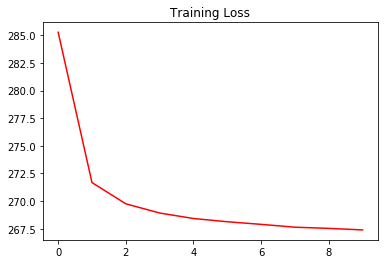

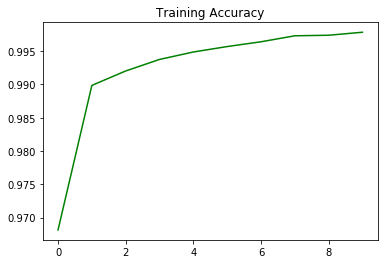

In [0]:
plt.plot(losses, c = 'r')
plt.title('Training Loss')
plt.show()
plt.plot(accs, c = 'g')
plt.title('Training Accuracy')
plt.show()

##Testing the model

In [0]:
acc = 0.0
batches = 0
for features, labels in test_data:
    features = features.as_in_context(ctx)
    labels = labels.as_in_context(ctx).one_hot(10)
    predictions = model(features, training = False)
    acc += accuracy(predictions, labels)
    batches += 1
print(f'Test Accuracy: {acc.asscalar()/batches}')

Test Accuracy: 0.9939291401273885
